In [1]:
import sys
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

import json
from pathlib import Path
import pickle

from tqdm import tqdm

from xmljson import badgerfish as bf
from xml.etree.ElementTree import fromstring

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/home/heye0507/drone/drone_benchmark/data/benchmark'
train_images = path + '/images'
test_images = path + '/test_images'
anno = path + '/annotation'

# Test skip

In [88]:
with open(anno+'/177R.xml','r') as f:
    data = f.read()

In [13]:
data

'<annotation>\n  <folder>7-16(1)</folder>\n  <path>D:\\&#20154;&#27969;&#35745;&#25968;&#26631;&#35760;\\&#20154;&#27969;&#35745;&#25968;&#26631;&#35760;\\7-16(1)\\1R.jpg</path>\n  <source>\n    <database>Unknown</database>\n  </source>\n  <size>\n    <width>640</width>\n    <height>512</height>\n    <depth>1</depth>\n  </size>\n  <segmented>0</segmented>\n  <object>\n    <name>person</name>\n    <pose>Unspecified</pose>\n    <truncated>0</truncated>\n    <difficult>0</difficult>\n    <point>\n      <x>239</x>\n      <y>192</y>\n    </point>\n  </object>\n  <object>\n    <name>person</name>\n    <pose>Unspecified</pose>\n    <truncated>0</truncated>\n    <difficult>0</difficult>\n    <point>\n      <x>244</x>\n      <y>178</y>\n    </point>\n  </object>\n  <object>\n    <name>person</name>\n    <pose>Unspecified</pose>\n    <truncated>0</truncated>\n    <difficult>0</difficult>\n    <point>\n      <x>264</x>\n      <y>196</y>\n    </point>\n  </object>\n  <object>\n    <name>person</na

In [188]:
test_data = bf.data(fromstring(data))

In [198]:
img_shape = test_data['annotation']['size']['height']['$'],test_data['annotation']['size']['width']['$']
img_shape

(512, 640)

In [43]:
test_data['annotation']['object'][0]

OrderedDict([('name', OrderedDict([('$', 'person')])),
             ('pose', OrderedDict([('$', 'Unspecified')])),
             ('truncated', OrderedDict([('$', 0)])),
             ('difficult', OrderedDict([('$', 0)])),
             ('point',
              OrderedDict([('x', OrderedDict([('$', 239)])),
                           ('y', OrderedDict([('$', 192)]))]))])

In [8]:
def get_annotation(xml_datas):
    points = []
    for data in xml_datas['annotation']['object']:
        if data['name']['$'] == 'person':
            if 'point' in data:
                x = data['point']['x']['$']
                y = data['point']['y']['$']
            else:
                x = data['bndbox']['xmin']['$']
                y = data['bndbox']['ymin']['$']
            points.append((x,y))
        else: print(data['name']['$'] +' not a person...')
    return points

def plot_data(img,points=None,fig_size=(18,12)):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    if points:
        for point in points:
#             x,y = datas['points']
#             point =(int(x),int(y))
            cv2.circle(image, point, radius=0,color=(0, 1, 0), thickness=5)
    ax.imshow(img)

In [36]:
with open(anno+'/656R.xml','r') as f:
    data = f.read()
    
test_data = bf.data(fromstring(data))
points = get_annotation(test_data)

filename = '/656.jpg'
folder = train_images
image = cv2.imread(folder+filename,cv2.IMREAD_COLOR)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
image = image/255.

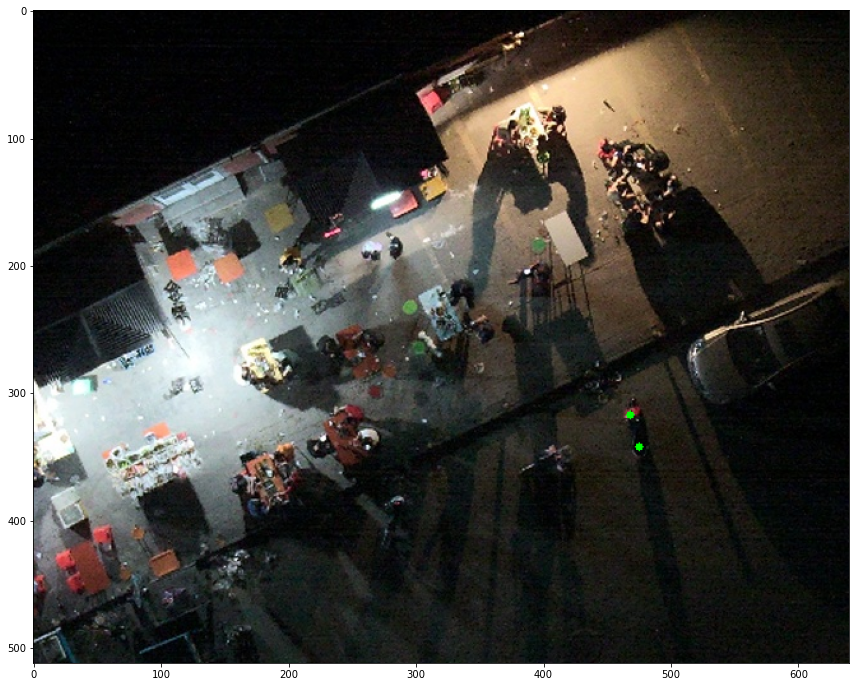

In [37]:
plot_data(image,points)

In [72]:
image.shape

(512, 640, 3)

# Tesk Skip Done

In [23]:
import scipy
import scipy.io as io
from scipy.ndimage.filters import gaussian_filter
def gaussian_filter_density(img,points):
    '''
    This code use k-nearst, will take one minute or more to generate a density-map with one thousand people.
    points: a two-dimension list of pedestrians' annotation with the order [[col,row],[col,row],...].
    img_shape: the shape of the image, same as the shape of required density-map. (row,col). Note that can not have channel.
    return:
    density: the density-map we want. Same shape as input image but only has one channel.
    example:
    points: three pedestrians with annotation:[[163,53],[175,64],[189,74]].
    img_shape: (768,1024) 768 is row and 1024 is column.
    '''
    img_shape=[img.shape[0],img.shape[1]]
    #print("Shape of current image: ",img_shape,". Totally need generate ",len(points),"gaussian kernels.")
    density = np.zeros(img_shape, dtype=np.float32)
    gt_count = len(points)
    if gt_count == 0:
        return density

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(points, k=4)

    #print ('generate density...')
    for i, pt in enumerate(points):
        pt2d = np.zeros(img_shape, dtype=np.float32)
        if int(pt[1])<img_shape[0] and int(pt[0])<img_shape[1]:
            pt2d[int(pt[1]),int(pt[0])] = 1.
        else:
            continue
        if gt_count > 3: # set to 3 since we looking for 3 neighbors, at least needs 4 gt_count
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = 15 #np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    #print ('done.')
    return density

In [38]:
%%time
d_map_1 = gaussian_filter_density(image,points)

CPU times: user 94.2 ms, sys: 2.95 ms, total: 97.2 ms
Wall time: 96.1 ms


In [39]:
d_map_1.sum()

1.9999999

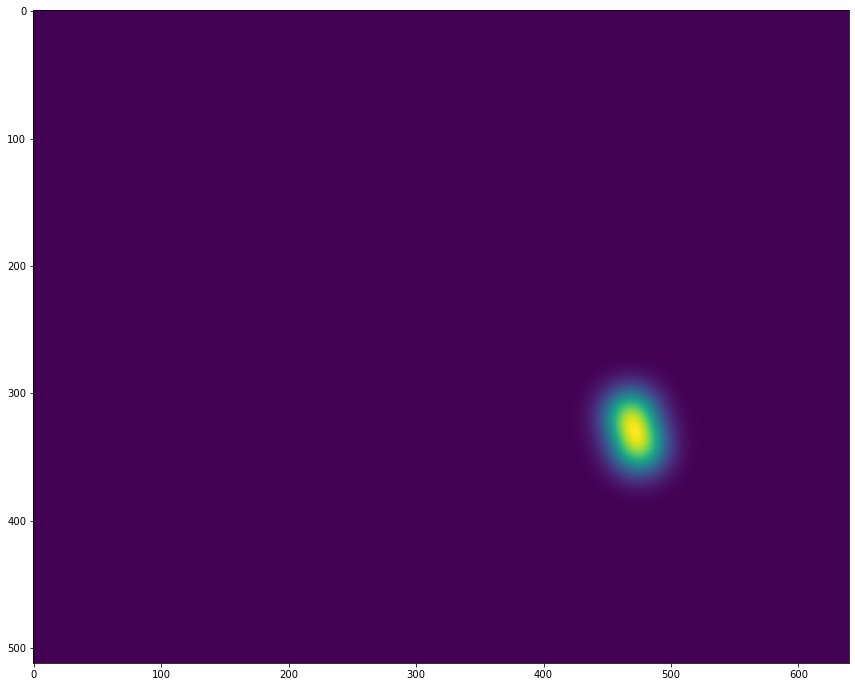

In [40]:
plot_data(d_map_1)

In [41]:
filename.split('.')

['/656', 'jpg']

In [42]:
out_f = dmap_folder + filename.split('.')[0]+'Dmap.pkl'
out_f

'/Users/haohe/Documents/HKUST/competition/data/VisDrone2021-COUNTING/DroneRGBT/Train/DMAP/656Dmap.pkl'

In [175]:
d_map_1

array([[1.29335636e-08, 1.44420600e-08, 1.60966263e-08, ...,
        2.41380876e-05, 2.33177871e-05, 2.25163731e-05],
       [1.51272435e-08, 1.68915975e-08, 1.88267961e-08, ...,
        2.44214825e-05, 2.35911029e-05, 2.27798591e-05],
       [1.76602217e-08, 1.97200087e-08, 2.19792469e-08, ...,
        2.46987984e-05, 2.38585344e-05, 2.30376536e-05],
       ...,
       [0.00000000e+00, 3.03091277e-08, 4.06006500e-08, ...,
        2.48793214e-07, 2.37040567e-07, 2.25742383e-07],
       [0.00000000e+00, 2.57969113e-08, 3.45563009e-08, ...,
        2.36090997e-07, 2.24938375e-07, 2.14217039e-07],
       [0.00000000e+00, 2.18367955e-08, 2.92515203e-08, ...,
        2.23937391e-07, 2.13358888e-07, 2.03189472e-07]], dtype=float32)

In [182]:
with open(out_f,'wb') as f:
    pickle.dump(d_map_1,f)

In [185]:
test_dmap = np.load(out_f,allow_pickle=True)

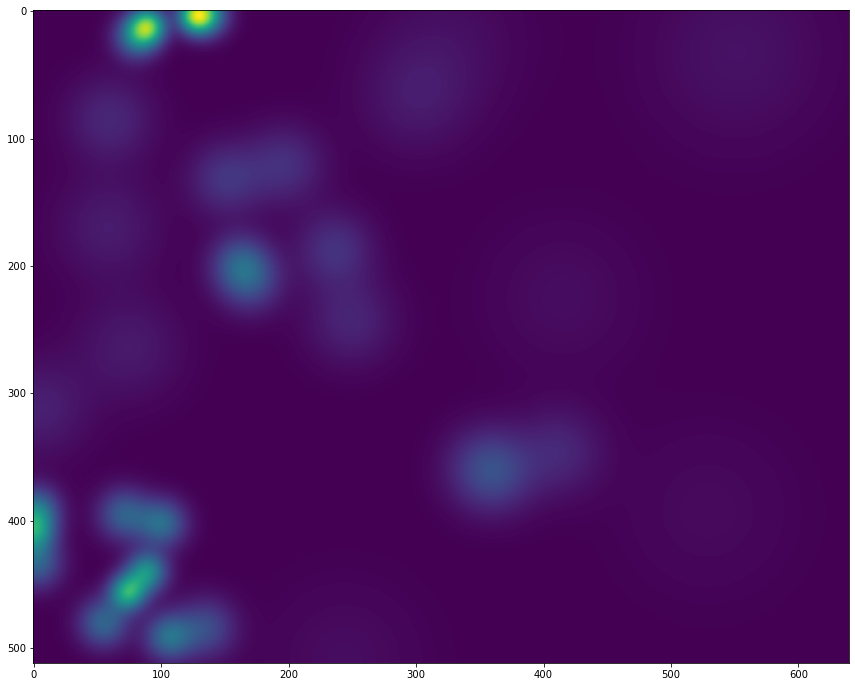

In [187]:
plot_data(test_dmap)

# Pack to class

In [9]:
file = sorted(glob(anno+'/*.xml'),key=lambda x: int(x.split('/')[-1].split('.')[0][:-1]))[0]
file.split('/')[-1].split('.')[0][:-1]+'Dmap.pkl'

'1Dmap.pkl'

In [229]:
for anno_file in sorted(glob(anno+'/*.xml'),key=lambda x: int(x.split('/')[-1].split('.')[0][:-1])):
    with open(anno_file,'r') as f:
        data = f.read()
    test_data = bf.data(fromstring(data))
    img_shape = test_data['annotation']['size']['height']['$'],test_data['annotation']['size']['width']['$']
    img = np.zeros(img_shape)
    points = get_annotation(test_data)
    d_map = gaussian_filter_density(img,points)
    break

Shape of current image:  [512, 640] . Totally need generate  15 gaussian kernels.
generate density...
done.


In [231]:
d_map.sum()

12.967792

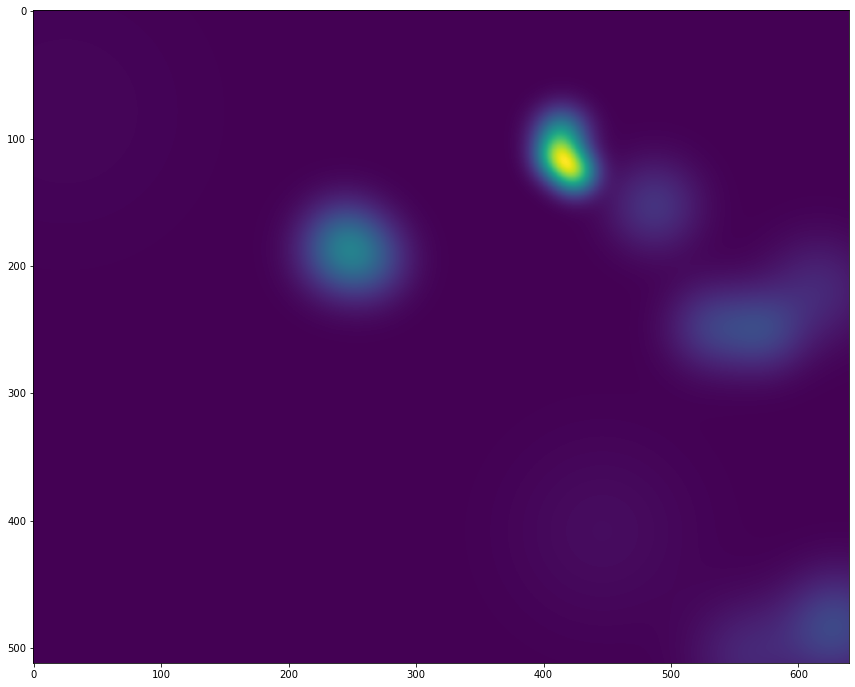

In [230]:
plot_data(d_map)

In [4]:
class VIS_PROC:
    def __init__(self,images_path,anno_path,output_path,kernel_func,test=False):
        self.images_path,self.anno_path,self.output_path = images_path,anno_path,output_path
        self.kernel_func = kernel_func
        self.test = test
        #self.output = []
        
        
    def run_proc(self):
        for anno_file in tqdm(sorted(glob(self.anno_path+'/*.xml'),key=lambda x: int(x.split('/')[-1].split('.')[0][:-1])),total=len(glob(self.anno_path+'/*.xml'))):
            with open(anno_file,'r') as f:
                data = f.read()
            try:
                test_data = bf.data(fromstring(data))
                img_shape = test_data['annotation']['size']['height']['$'],test_data['annotation']['size']['width']['$']
                img = np.zeros(img_shape)
                points = self._get_annotation(test_data)
                d_map = self.kernel_func(img,points)
                fname = anno_file.split('/')[-1].split('.')[0][:-1] + 'Dmap.pkl'
                out_filename = self.output_path + '/' + fname
                with open(out_filename,'wb') as f:
                    pickle.dump(d_map,f)
            except:
                print(anno_file)
                e = sys.exc_info()[0]
                print(e)
            if self.test:
                raise ValueError('Test Stop...')
#             outp_file = self.output_path + '/gt_dmap.pkl'
#             with open(outp_file,'wb') as f:
#                 pickle.dump(self.output,f)
        
    
    def _get_annotation(self,xml_datas):
        points = []
        for data in xml_datas['annotation']['object']:
            if data['name']['$'] == 'person' or data['name']['$'] == 'person]':
                if 'point' in data:
                    x = data['point']['x']['$']
                    y = data['point']['y']['$']
                else:
                    x = data['bndbox']['xmin']['$']
                    y = data['bndbox']['ymin']['$']
                points.append((x,y))
            else: print(data['name']['$'] +' not a person...')
        return points

#     def plot_data(img,points=None,fig_size=(18,12)):
#         fig, ax = plt.subplots(1, 1, figsize=fig_size)
#         if points:
#             for point in points:
#     #             x,y = datas['points']
#     #             point =(int(x),int(y))
#                 cv2.circle(image, point, radius=0,color=(0, 1, 0), thickness=5)
#         ax.imshow(img)
        

In [5]:
vis_drone_proc = VIS_PROC(None,anno,path + '/Train/DMAP',gaussian_filter_density)

In [6]:
vis_drone_proc.run_proc()

 35%|███▌      | 635/1807 [18:05<47:54,  2.45s/it]  

/Users/haohe/Documents/HKUST/competition/data/VisDrone2021-COUNTING/DroneRGBT/Train/GT_/636R.xml
<class 'OverflowError'>


 36%|███▌      | 655/1807 [18:19<12:55,  1.49it/s]

/Users/haohe/Documents/HKUST/competition/data/VisDrone2021-COUNTING/DroneRGBT/Train/GT_/656R.xml
<class 'OverflowError'>


100%|██████████| 1807/1807 [56:07<00:00,  1.86s/it] 


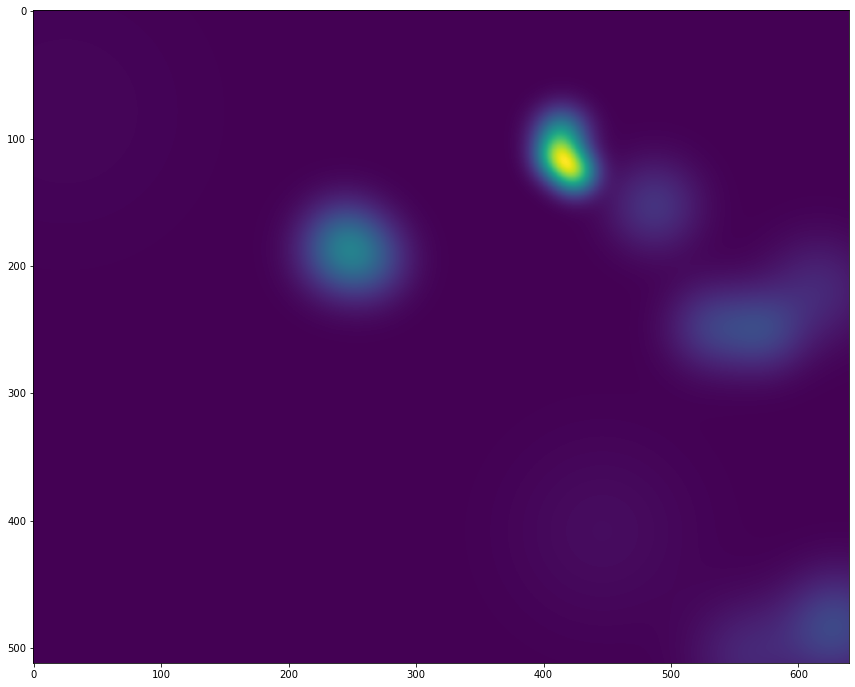

In [19]:
plot_data(np.load(dmap_folder + '/1Dmap.pkl',allow_pickle=True))